In [2]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
import tensorflow as tf
import numpy as np
from PIL import Image

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("TensorFlow is configured to use the following GPUs:")
    for gpu in gpus:
        print(gpu)
else:
    print("TensorFlow is not configured to use any GPUs.")

# want to speed up training lol - maybe I can try VGG16
# This was done on my desktop with a 3060Ti

TensorFlow is configured to use the following GPUs:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
print(np.asarray(Image.open('Data/damage/-93.795_30.03779.jpeg')).shape)

(128, 128, 3)


In [16]:
# AI Generated, See [1]
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Load color JPEG images from directory structure:
# Data/
#   ├── damage/
#   └── no_damage/

dataset = image_dataset_from_directory(
    'Data',
    image_size=(128, 128),
    batch_size=32,
    label_mode='binary',
    color_mode='rgb',  # load as color for now.
    shuffle=True,
    seed=1
)

# Normalize pixel values to [0, 1] range for better training
normalization_layer = tf.keras.layers.Rescaling(1./255)
dataset = dataset.map(lambda x, y: (normalization_layer(x), y))

# Optimize performance
dataset = dataset.prefetch(tf.data.AUTOTUNE)

print(f"Dataset created. Each batch shape: (batch_size, 128, 128, 3)")

Found 21322 files belonging to 2 classes.
Dataset created. Each batch shape: (batch_size, 128, 128, 3)


In [6]:
size = tf.data.experimental.cardinality(dataset).numpy()
train_size = int(0.7*size)
eval_size = int(0.15*size)
test_size = size - train_size - eval_size ## used examples and documentation on tensorflow datasets to figure out how to split the tf dataset.

train_set = dataset.take(train_size)
eval_set = dataset.skip(train_size).take(eval_size)
test_set = dataset.skip(train_size + eval_size).take(test_size)

INPUT_SHAPE = (128, 128, 3)

In [7]:
model = Sequential()

model.add(Flatten(input_shape=INPUT_SHAPE))
model.add(Dense(8192, activation='relu', input_shape=(128*128*3,)))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # google search yielded that sigmoid is best for binary classification
# I also know we did as many outputs as classes for multi-class classification, but this made sense for binary classification.
# our decision function will be whether output > 0.5.

In [8]:
model.compile(optimizer=Adam(learning_rate=0.001), # tweaked learning rate for optimal validation accuracy...
              loss='binary_crossentropy', # This is used for binary classification
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 8192)              402661376 
                                                                 
 dense_1 (Dense)             (None, 512)               4194816   
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 406,856,705
Trainable params: 406,856,705
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.fit(train_set, validation_data=eval_set, epochs=10, batch_size=32, verbose=2)

Epoch 1/10
466/466 - 28s - loss: 2.1829 - accuracy: 0.6406 - val_loss: 0.6086 - val_accuracy: 0.6656 - 28s/epoch - 61ms/step
Epoch 2/10
466/466 - 28s - loss: 0.6037 - accuracy: 0.6912 - val_loss: 0.6005 - val_accuracy: 0.6850 - 28s/epoch - 60ms/step
Epoch 3/10
466/466 - 28s - loss: 0.5818 - accuracy: 0.7039 - val_loss: 0.6081 - val_accuracy: 0.6947 - 28s/epoch - 59ms/step
Epoch 4/10
466/466 - 28s - loss: 0.5727 - accuracy: 0.7214 - val_loss: 0.6248 - val_accuracy: 0.6925 - 28s/epoch - 60ms/step
Epoch 5/10
466/466 - 29s - loss: 0.5704 - accuracy: 0.7217 - val_loss: 0.5795 - val_accuracy: 0.7122 - 29s/epoch - 62ms/step
Epoch 6/10
466/466 - 28s - loss: 0.5612 - accuracy: 0.7334 - val_loss: 0.5546 - val_accuracy: 0.7344 - 28s/epoch - 61ms/step
Epoch 7/10
466/466 - 29s - loss: 0.5804 - accuracy: 0.7141 - val_loss: 0.5565 - val_accuracy: 0.7303 - 29s/epoch - 62ms/step
Epoch 8/10
466/466 - 29s - loss: 0.5577 - accuracy: 0.7288 - val_loss: 0.5608 - val_accuracy: 0.7366 - 29s/epoch - 61ms/step


In [9]:
print("Evaluating model on the test set...")
loss, accuracy = model.evaluate(test_set)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Evaluating model on the test set...
101/101 [==============================] - 2s 9ms/step - loss: 0.5653 - accuracy: 0.7137
Test Loss: 0.5652936697006226
Test Accuracy: 0.7137071490287781


## Review
We got 71.3% accuracy with the ANN on damage classification. Not abysmal, but not even 3/4 accurate.

## LeNet-5 Architecture

In [9]:
# Generated by AI - see [2]
import gc

del model  # Delete the model object
tf.keras.backend.clear_session()  # Clear the Keras backend session
gc.collect()  # Force garbage collection

405

In [25]:
# from readthedocs for COE379L

model = Sequential()

# Layer 1: Convolutional layer with 6 filters of size 5x5, followed by average pooling
model.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=INPUT_SHAPE))
model.add(AveragePooling2D(pool_size=(2, 2)))

# Layer 2: Convolutional layer with 16 filters of size 5x5, followed by average pooling
model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
model.add(AveragePooling2D(pool_size=(2, 2)))

# Flatten the feature maps to feed into fully connected layers
model.add(Flatten())

# Layer 3: Fully connected layer with 120 neurons
model.add(Dense(120, activation='relu'))

# Layer 4: Fully connected layer with 84 neurons
model.add(Dense(84, activation='relu'))

# Output layer: Fully connected layer with num_classes neurons (e.g., 10 for MNIST)
model.add(Dense(1, activation='sigmoid'))  # Using sigmoid for binary classification

In [26]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 6)       456       
                                                                 
 average_pooling2d (AverageP  (None, 62, 62, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 29, 29, 16)       0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 13456)             0         
                                                                 
 dense (Dense)               (None, 120)               1

In [27]:
model.fit(train_set, validation_data=eval_set, epochs=20, batch_size=32, verbose=2)

Epoch 1/20
466/466 - 6s - loss: 0.4877 - accuracy: 0.7623 - val_loss: 0.2477 - val_accuracy: 0.9000 - 6s/epoch - 14ms/step
Epoch 2/20
466/466 - 6s - loss: 0.2384 - accuracy: 0.9068 - val_loss: 0.1885 - val_accuracy: 0.9209 - 6s/epoch - 13ms/step
Epoch 3/20
466/466 - 6s - loss: 0.2021 - accuracy: 0.9221 - val_loss: 0.1943 - val_accuracy: 0.9219 - 6s/epoch - 13ms/step
Epoch 4/20
466/466 - 6s - loss: 0.1619 - accuracy: 0.9372 - val_loss: 0.1546 - val_accuracy: 0.9350 - 6s/epoch - 12ms/step
Epoch 5/20
466/466 - 6s - loss: 0.1365 - accuracy: 0.9464 - val_loss: 0.1441 - val_accuracy: 0.9431 - 6s/epoch - 13ms/step
Epoch 6/20
466/466 - 6s - loss: 0.1371 - accuracy: 0.9474 - val_loss: 0.1876 - val_accuracy: 0.9294 - 6s/epoch - 13ms/step
Epoch 7/20
466/466 - 6s - loss: 0.0859 - accuracy: 0.9692 - val_loss: 0.1660 - val_accuracy: 0.9347 - 6s/epoch - 12ms/step
Epoch 8/20
466/466 - 6s - loss: 0.0740 - accuracy: 0.9740 - val_loss: 0.1469 - val_accuracy: 0.9462 - 6s/epoch - 12ms/step
Epoch 9/20
466/4

In [28]:
print("Evaluating model on the test set...")
loss, accuracy = model.evaluate(test_set)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Evaluating model on the test set...
101/101 [==============================] - 2s 7ms/step - loss: 0.2875 - accuracy: 0.9402
Test Loss: 0.2874923050403595
Test Accuracy: 0.9401868581771851


## Review
The LeNet-5 model, with only specification of input size and modification of output layer to fit our classification needs, achieved 94% accuracy, stunningly better than a pure ANN.

## Alternate-LeNet-5

Using the following implementation as outlined in the linked research paper.

https://arxiv.org/pdf/1807.01688

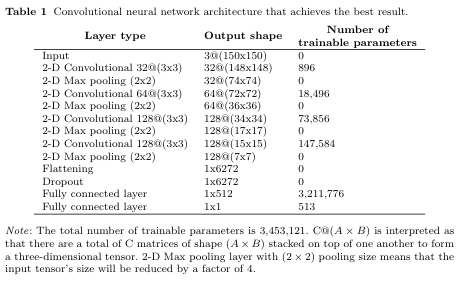

In [ ]:
del model  # Delete the model object
tf.keras.backend.clear_session()  # Clear the Keras backend session
gc.collect()  # Force garbage collection

1620

In [10]:
# reconstructed from Quoc Dung Cao, Youngjun Choe research paper linked above

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=INPUT_SHAPE))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(512, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

In [34]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In [35]:
model.fit(train_set, validation_data=eval_set, epochs=20, batch_size=32, verbose=2)

Epoch 1/20
466/466 - 9s - loss: 0.3474 - accuracy: 0.8470 - val_loss: 0.1996 - val_accuracy: 0.9191 - 9s/epoch - 18ms/step
Epoch 2/20
466/466 - 7s - loss: 0.1778 - accuracy: 0.9319 - val_loss: 0.1495 - val_accuracy: 0.9412 - 7s/epoch - 15ms/step
Epoch 3/20
466/466 - 7s - loss: 0.1538 - accuracy: 0.9411 - val_loss: 0.1291 - val_accuracy: 0.9497 - 7s/epoch - 16ms/step
Epoch 4/20
466/466 - 7s - loss: 0.1199 - accuracy: 0.9545 - val_loss: 0.0982 - val_accuracy: 0.9638 - 7s/epoch - 16ms/step
Epoch 5/20
466/466 - 7s - loss: 0.1168 - accuracy: 0.9561 - val_loss: 0.1072 - val_accuracy: 0.9616 - 7s/epoch - 16ms/step
Epoch 6/20
466/466 - 7s - loss: 0.0910 - accuracy: 0.9667 - val_loss: 0.1278 - val_accuracy: 0.9534 - 7s/epoch - 16ms/step
Epoch 7/20
466/466 - 7s - loss: 0.0847 - accuracy: 0.9678 - val_loss: 0.1191 - val_accuracy: 0.9512 - 7s/epoch - 15ms/step
Epoch 8/20
466/466 - 7s - loss: 0.0771 - accuracy: 0.9710 - val_loss: 0.1312 - val_accuracy: 0.9559 - 7s/epoch - 15ms/step
Epoch 9/20
466/4

In [36]:
print("Evaluating model on the test set...")
loss, accuracy = model.evaluate(test_set)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Evaluating model on the test set...
101/101 [==============================] - 2s 8ms/step - loss: 0.0690 - accuracy: 0.9723
Test Loss: 0.06901176273822784
Test Accuracy: 0.972274124622345


## Review
Nice! We're getting significantly higher than even the regular LeNet5 implementation! 97.2% test accuracy.

Let's try an alternate implementation I saw in the research paper using full dropout

In [11]:
del model  # Delete the model object
tf.keras.backend.clear_session()  # Clear the Keras backend session
gc.collect()  # Force garbage collection

1496

In [18]:
# reconstructed from Quoc Dung Cao, Youngjun Choe research paper linked above

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=INPUT_SHAPE))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(512, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

In [13]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 30, 30, 64)        0

In [14]:
model.fit(train_set, validation_data=eval_set, epochs=20, batch_size=32, verbose=2)

Epoch 1/20
466/466 - 14s - loss: 0.4298 - accuracy: 0.8050 - val_loss: 0.2053 - val_accuracy: 0.9262 - 14s/epoch - 30ms/step
Epoch 2/20
466/466 - 8s - loss: 0.1968 - accuracy: 0.9272 - val_loss: 0.1491 - val_accuracy: 0.9384 - 8s/epoch - 16ms/step
Epoch 3/20
466/466 - 8s - loss: 0.1473 - accuracy: 0.9448 - val_loss: 0.1412 - val_accuracy: 0.9525 - 8s/epoch - 17ms/step
Epoch 4/20
466/466 - 8s - loss: 0.1342 - accuracy: 0.9486 - val_loss: 0.1384 - val_accuracy: 0.9541 - 8s/epoch - 16ms/step
Epoch 5/20
466/466 - 8s - loss: 0.1177 - accuracy: 0.9553 - val_loss: 0.1087 - val_accuracy: 0.9613 - 8s/epoch - 16ms/step
Epoch 6/20
466/466 - 8s - loss: 0.1134 - accuracy: 0.9586 - val_loss: 0.1008 - val_accuracy: 0.9641 - 8s/epoch - 16ms/step
Epoch 7/20
466/466 - 8s - loss: 0.1112 - accuracy: 0.9592 - val_loss: 0.1058 - val_accuracy: 0.9597 - 8s/epoch - 16ms/step
Epoch 8/20
466/466 - 8s - loss: 0.0979 - accuracy: 0.9626 - val_loss: 0.0776 - val_accuracy: 0.9716 - 8s/epoch - 16ms/step
Epoch 9/20
466

In [15]:
print("Evaluating model on the test set...")
loss, accuracy = model.evaluate(test_set)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Evaluating model on the test set...
101/101 [==============================] - 3s 13ms/step - loss: 0.0634 - accuracy: 0.9785
Test Loss: 0.06337141245603561
Test Accuracy: 0.9785046577453613


## Review
Full dropout slightly improved test performance to 97.85% accuracy, showing its possible value in combating overfitting. Let's go ahead and persist this model.

In [16]:
model.save('LeNetFullDropout.keras')

Let's finish off with some VGG16!

In [17]:
del model  # Delete the model object
tf.keras.backend.clear_session()  # Clear the Keras backend session
gc.collect()  # Force garbage collection

76

In [20]:
from keras.applications.vgg16 import VGG16

# Following aided significantly by AI - see [3]
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

vgg_base.trainable = False  # Freeze the base model

# 3. Create a new model with custom top layers
model = Sequential()
model.add(vgg_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5)) # Regularization to prevent overfitting
model.add(Dense(1, activation='sigmoid')) # Single neuron with sigmoid for binary classification

# 4. Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001), # Lower learning rate often better for transfer learning
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [44]:
model.fit(train_set, validation_data=eval_set, epochs=10, batch_size=32, verbose=2)

Epoch 1/10
466/466 - 18s - loss: 0.2548 - accuracy: 0.8989 - val_loss: 0.2039 - val_accuracy: 0.9203 - 18s/epoch - 38ms/step
Epoch 2/10
466/466 - 17s - loss: 0.1924 - accuracy: 0.9262 - val_loss: 0.1783 - val_accuracy: 0.9303 - 17s/epoch - 36ms/step
Epoch 3/10
466/466 - 17s - loss: 0.1704 - accuracy: 0.9334 - val_loss: 0.1660 - val_accuracy: 0.9331 - 17s/epoch - 37ms/step
Epoch 4/10
466/466 - 17s - loss: 0.1551 - accuracy: 0.9415 - val_loss: 0.1590 - val_accuracy: 0.9322 - 17s/epoch - 37ms/step
Epoch 5/10
466/466 - 17s - loss: 0.1433 - accuracy: 0.9443 - val_loss: 0.1562 - val_accuracy: 0.9337 - 17s/epoch - 37ms/step
Epoch 6/10
466/466 - 17s - loss: 0.1334 - accuracy: 0.9472 - val_loss: 0.1530 - val_accuracy: 0.9362 - 17s/epoch - 37ms/step
Epoch 7/10
466/466 - 17s - loss: 0.1246 - accuracy: 0.9521 - val_loss: 0.1503 - val_accuracy: 0.9394 - 17s/epoch - 37ms/step
Epoch 8/10
466/466 - 17s - loss: 0.1169 - accuracy: 0.9560 - val_loss: 0.1522 - val_accuracy: 0.9366 - 17s/epoch - 36ms/step


In [45]:
print("Evaluating model on the test set...")
loss, accuracy = model.evaluate(test_set)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Evaluating model on the test set...
101/101 [==============================] - 4s 30ms/step - loss: 0.1548 - accuracy: 0.9361
Test Loss: 0.15479429066181183
Test Accuracy: 0.9361370205879211


## Review

This method has a lower accuracy than our LeNet tests, but let's try and unfreeze the base model...

In [21]:
del model  # Delete the model object
tf.keras.backend.clear_session()  # Clear the Keras backend session
gc.collect()  # Force garbage collection

vgg_base.trainable = True  # Unfreeze the base model for fine-tuning

# 3. Create a new model with custom top layers
model = Sequential()
model.add(vgg_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5)) # Regularization to prevent overfitting
model.add(Dense(1, activation='sigmoid')) # Single neuron with sigmoid for binary classification

# 4. Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001), # Lower learning rate often better for transfer learning
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.fit(train_set, validation_data=eval_set, epochs=10, batch_size=32, verbose=2)

Epoch 1/10
466/466 - 51s - loss: 0.1921 - accuracy: 0.9238 - val_loss: 0.1273 - val_accuracy: 0.9484 - 51s/epoch - 109ms/step
Epoch 2/10
466/466 - 50s - loss: 0.0786 - accuracy: 0.9714 - val_loss: 0.0519 - val_accuracy: 0.9825 - 50s/epoch - 108ms/step
Epoch 3/10
466/466 - 50s - loss: 0.0598 - accuracy: 0.9796 - val_loss: 0.0656 - val_accuracy: 0.9803 - 50s/epoch - 108ms/step
Epoch 4/10
466/466 - 51s - loss: 0.0620 - accuracy: 0.9784 - val_loss: 0.0473 - val_accuracy: 0.9800 - 51s/epoch - 108ms/step
Epoch 5/10
466/466 - 50s - loss: 0.0372 - accuracy: 0.9872 - val_loss: 0.0446 - val_accuracy: 0.9819 - 50s/epoch - 108ms/step
Epoch 6/10
466/466 - 51s - loss: 0.0247 - accuracy: 0.9913 - val_loss: 0.0336 - val_accuracy: 0.9897 - 51s/epoch - 109ms/step
Epoch 7/10
466/466 - 51s - loss: 0.0312 - accuracy: 0.9900 - val_loss: 0.0508 - val_accuracy: 0.9812 - 51s/epoch - 108ms/step
Epoch 8/10
466/466 - 50s - loss: 0.0180 - accuracy: 0.9940 - val_loss: 0.0522 - val_accuracy: 0.9809 - 50s/epoch - 108

In [23]:
print("Evaluating model on the test set...")
loss, accuracy = model.evaluate(test_set)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Evaluating model on the test set...
101/101 [==============================] - 4s 28ms/step - loss: 0.0486 - accuracy: 0.9826
Test Loss: 0.0486268512904644
Test Accuracy: 0.9825544953346252


## Review
This is our highest accuracy yet, achieving 98.25% accuracy on the test set!

However, considering possible tradeoffs of the different algorithms, this begs the question of whether it is worth the 0.4% accuracy improvement for the massive increase in model weight and cost for inference.

Let's try persisting the VGG16 and testing if the inference server runs on the VM...

In [24]:
## save model
model.save('vgg16Variant.keras')

In [18]:
model = tf.keras.models.load_model('vgg16Variant.keras')

In [ ]:
test = Image.open('Data/damage/-97.001016_28.446817.jpeg')
test = np.asarray(test).reshape((1, 128, 128, 3)) / 255.0
prediction = model.predict(test)

if prediction[0][0] <= 0.5:
    word = "damage"
else:
    word = "no_damage"

print(f"Prediction: {prediction}")
print(word)

1/1 [==============================] - 0s 104ms/step
Prediction: [[0.01878772]]
The model predicts: damage


With this test, we've concluded parts 1 & 2 of the project. The packaging of this VGG16 inference server is available in the directory titled part3